# Class 09: KNN & Deployment with Gradio


---
## Generate Data

In [1]:
import numpy as np
np.random.seed(42)

n_samples = 100
sqft = np.random.randint(500, 3000, n_samples)
bedrooms = np.random.randint(1, 6, n_samples)

price = 50000 + (sqft * 100) + (bedrooms * 20000) + np.random.normal(0, 20000, n_samples)

X = np.column_stack([sqft, bedrooms])
y = price

print(f"Generated {n_samples} houses")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nFeature ranges:")
print(f"Square Feet: {sqft.min()} - {sqft.max()}")
print(f"Bedrooms: {bedrooms.min()} - {bedrooms.max()}")
print(f"Price: ${y.min():,.0f} - ${y.max():,.0f}")

Generated 100 houses
X shape: (100, 2)
y shape: (100,)

Feature ranges:
Square Feet: 521 - 2949
Bedrooms: 1 - 5
Price: $122,739 - $447,225


---
## KNN Regression

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {len(X_train)} samples")
print(f"Test: {len(X_test)} samples")

Train: 80 samples
Test: 20 samples


In [4]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

knn_no_scale = KNeighborsRegressor(n_neighbors=5)
knn_no_scale.fit(X_train, y_train)
y_pred_no_scale = knn_no_scale.predict(X_test)

print("WITHOUT Scaling:")
print(f"R² = {r2_score(y_test, y_pred_no_scale):.3f}")

WITHOUT Scaling:
R² = 0.709


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

pipeline.fit(X_train, y_train)
y_pred_scaled = pipeline.predict(X_test)

print("WITH Scaling (Pipeline):")
print(f"R² = {r2_score(y_test, y_pred_scaled):.3f}")

WITH Scaling (Pipeline):
R² = 0.833


---
## Choosing K

In [7]:
import matplotlib.pyplot as plt

k_values = range(1, 31)
train_errors = []
test_errors = []

for k in k_values:
    pipeline_k = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsRegressor(n_neighbors=k))
    ])
    pipeline_k.fit(X_train, y_train)

    train_errors.append(mean_squared_error(y_train, pipeline_k.predict(X_train)))
    test_errors.append(mean_squared_error(y_test, pipeline_k.predict(X_test)))

In [8]:
best_k = k_values[np.argmin(test_errors)]
print(f"Best K: {best_k}")
print(f"Best Test MSE: ${min(test_errors):,.0f}")

Best K: 3
Best Test MSE: $834,944,711


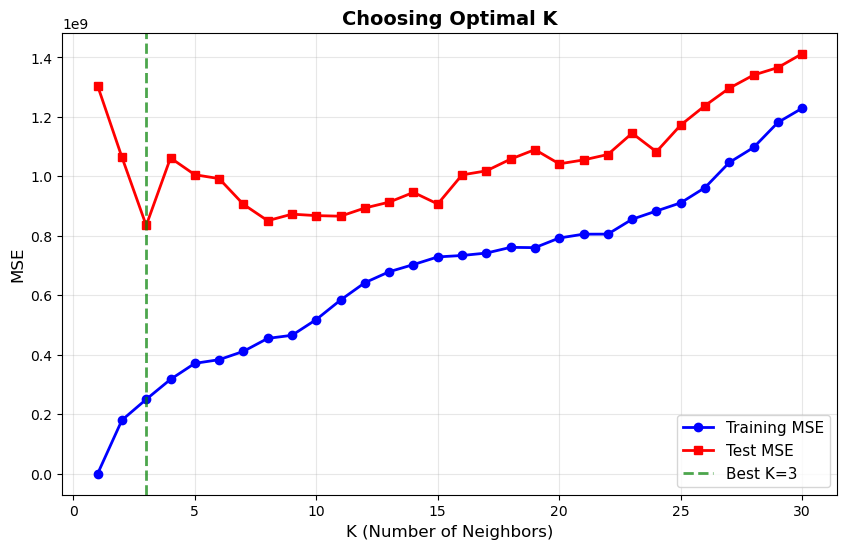

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_errors, 'bo-', label='Training MSE', linewidth=2, markersize=6)
plt.plot(k_values, test_errors, 'rs-', label='Test MSE', linewidth=2, markersize=6)
plt.axvline(best_k, color='green', linestyle='--', linewidth=2, alpha=0.7, label=f'Best K={best_k}') #axvline what it does -> vertical line
plt.xlabel('K (Number of Neighbors)', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('Choosing Optimal K', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

---
## Save and Load Model

In [12]:
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=best_k))
])

final_pipeline.fit(X_train, y_train)

print(f"Trained final model with K={best_k}")
print(f"Test R²: {r2_score(y_test, final_pipeline.predict(X_test)):.3f}")

Trained final model with K=3
Test R²: 0.862


In [13]:
import joblib

joblib.dump(final_pipeline, 'house_price_knn.pkl')

['house_price_knn.pkl']

In [14]:
loaded_pipeline = joblib.load('house_price_knn.pkl')

In [ ]:
test_house = [[1500, 3]]  # 1500 sqft, 3 bedrooms
prediction = loaded_pipeline.predict(test_house)[0]

print(f"Predicted Price: ${prediction:,.0f}")

Predicted Price: $270,552


---
## Gradio Deployment

Build a web app with:
- Input sliders for Square Feet, Bedrooms, K
- Output: Predicted price + Visualization showing K neighbors

In [16]:
!pip install gradio

In [17]:
import gradio as gr

def predict_simple(sqft, bedrooms):
    prediction = loaded_pipeline.predict([[sqft, bedrooms]])[0]
    return f"${prediction:,.0f}"

interface = gr.Interface(
    fn=predict_simple,
    inputs=[
        gr.Slider(500, 3000, value=1500, label="Square Feet"),
        gr.Slider(1, 5, value=3, step=1, label="Bedrooms")
    ],
    outputs=gr.Textbox(label="Predicted Price"),
    title="🏠 Simple House Price Predictor"
)

interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://b17d9b206b1131f56f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [20]:
def predict_and_visualize(sqft, bedrooms):
    X_new = np.array([[sqft, bedrooms]])
    prediction = loaded_pipeline.predict(X_new)[0]

    knn_model = loaded_pipeline.named_steps['knn']
    X_new_scaled = loaded_pipeline.named_steps['scaler'].transform(X_new)
    distances, indices = knn_model.kneighbors(X_new_scaled)
    neighbor_indices = indices[0]

    k = knn_model.n_neighbors

    fig, ax = plt.subplots(figsize=(10, 8))

    ax.scatter(X_train[:, 0], X_train[:, 1],
              c='lightgray', s=100, alpha=0.5,
              edgecolors='gray', linewidth=0.5,
              label='Other Houses')

    ax.scatter(X_train[neighbor_indices, 0], X_train[neighbor_indices, 1],
              c='lime', s=300, edgecolors='darkgreen', linewidth=2,
              label=f'{k} Nearest Neighbors', zorder=3)

    for idx in neighbor_indices:
        ax.plot([sqft, X_train[idx, 0]],
               [bedrooms, X_train[idx, 1]],
               'g--', alpha=0.6, linewidth=2, zorder=2)

    ax.scatter([sqft], [bedrooms],
              c='red', s=800, marker='*',
              edgecolors='darkred', linewidth=3,
              label='Your House', zorder=5)

    ax.set_xlabel('Square Feet', fontsize=14, fontweight='bold')
    ax.set_ylabel('Bedrooms', fontsize=14, fontweight='bold')
    ax.set_title(f'KNN Prediction: ${prediction:,.0f}',
                fontsize=16, fontweight='bold', pad=20)
    ax.legend(loc='best', fontsize=12, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xlim(X_train[:, 0].min() - 100, X_train[:, 0].max() + 100)
    ax.set_ylim(X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5)

    plt.tight_layout()

    return f"${prediction:,.0f}", fig

In [22]:
interface = gr.Interface(
    fn=predict_and_visualize,
    inputs=[
        gr.Number(value=1500, label="Square Feet"),
        gr.Slider(1, 5, value=3, step=1, label="Bedrooms")
    ],
    outputs=[
        gr.Textbox(label="Predicted Price"),
        gr.Plot(label="KNN Visualization")
    ],
    title="🏠 House Price Predictor",
    description="Uses pre-trained KNN model"
).launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.
